# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dogImages`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

### After donwloading the Datasets from provided links:
https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip
### Files were unizipped and placed in Project Folder.
### Link for the project Git  is:

In [1]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("lfw/*/*"))
dog_files = np.array(glob("dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


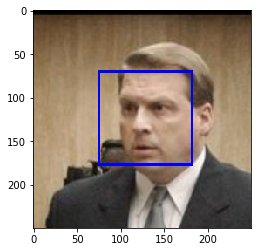

In [2]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [3]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
(You can print out your results and/or write your percentages in this cell)

In [4]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
counter=0
for human in human_files_short:
    face = face_detector(human)
    if face:
        counter = counter+1
print("Human Files in Human Folder (Percentage): {}".format(str(counter*100/len(human_files_short))))

counter = 0
for dog in dog_files_short:

    face = face_detector(dog)
    if face:
        counter = counter+1
print("Human Files in Dog Folder (Percentage): {}".format(str(counter*100/len(dog_files_short))))

Human Files in Human Folder (Percentage): 98.0
Human Files in Dog Folder (Percentage): 6.0


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [ ]:
### (Optional) 
### TODO: Test performance of another face detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [5]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()
    print("using cuda.")

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/ec2-user/.cache/torch/checkpoints/vgg16-397923af.pth


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [6]:
from PIL import Image
# Set PIL to be tolerant of image files that are truncated.
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


def safe_pil_loader(path, from_memory=False):
    try:
        if from_memory:
            img = Image.open(path)
            res = img.convert('RGB')
        else:
            with open(path, 'rb') as f:
                img = Image.open(f)
                res = img.convert('RGB')
    except:
        res = Image.new('RGB', (227, 227), color=0)
    return res


def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    image = safe_pil_loader(img_path)
    
    data_transform = transforms.Compose([transforms.RandomResizedCrop(224), 
                                         transforms.CenterCrop(224),
                                      transforms.ToTensor()])
    image = data_transform(image)

    my_Dataloader = torch.utils.data.DataLoader(image, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)
    
    VGG16.eval() # eval mode

    # iterate over test data
    for data in my_Dataloader:
        # forward pass: compute predicted outputs by passing inputs to the model
        data = data.unsqueeze(0)
        output = VGG16(data)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)    

    return pred

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [7]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    detection = VGG16_predict(img_path)
    if 151<= detection <=268:
        return True
    else:
        return False

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 
Dogs Detected percentage in human_files_short: 80.0
Dogs Detected percentage in dog_files_short: 79.0

In [156]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
## suggested code, below
countdogs = 0
for humans in np.hstack(human_files_short):
    result = dog_detector(os.getcwd()+'/'+file)
    if result:
        countdogs = countdogs +1
print("Dogs Detected percentage in human_files_short: {}".format(countdogs*100/len(dog_files_short)))
    
countdogs = 0
for dogs in np.hstack(dog_files_short):
    result = dog_detector(os.getcwd()+'/'+file)
    if result:
        countdogs = countdogs +1
print("Dogs Detected percentage in dog_files_short: {}".format(countdogs*100/len(dog_files_short)))
    

/home/ec2-user/SageMaker/dog_breed_udacity/dogImages/test/072.German_shorthaired_pointer/German_shorthaired_pointer_04971.jpg
tensor([178])
/home/ec2-user/SageMaker/dog_breed_udacity/dogImages/test/072.German_shorthaired_pointer/German_shorthaired_pointer_04971.jpg
tensor([178])
/home/ec2-user/SageMaker/dog_breed_udacity/dogImages/test/072.German_shorthaired_pointer/German_shorthaired_pointer_04971.jpg
tensor([431])
/home/ec2-user/SageMaker/dog_breed_udacity/dogImages/test/072.German_shorthaired_pointer/German_shorthaired_pointer_04971.jpg
tensor([178])
/home/ec2-user/SageMaker/dog_breed_udacity/dogImages/test/072.German_shorthaired_pointer/German_shorthaired_pointer_04971.jpg
tensor([208])
/home/ec2-user/SageMaker/dog_breed_udacity/dogImages/test/072.German_shorthaired_pointer/German_shorthaired_pointer_04971.jpg
tensor([669])
/home/ec2-user/SageMaker/dog_breed_udacity/dogImages/test/072.German_shorthaired_pointer/German_shorthaired_pointer_04971.jpg
tensor([750])
/home/ec2-user/SageM

tensor([178])
/home/ec2-user/SageMaker/dog_breed_udacity/dogImages/test/072.German_shorthaired_pointer/German_shorthaired_pointer_04971.jpg
tensor([178])
/home/ec2-user/SageMaker/dog_breed_udacity/dogImages/test/072.German_shorthaired_pointer/German_shorthaired_pointer_04971.jpg
tensor([178])
/home/ec2-user/SageMaker/dog_breed_udacity/dogImages/test/072.German_shorthaired_pointer/German_shorthaired_pointer_04971.jpg
tensor([178])
/home/ec2-user/SageMaker/dog_breed_udacity/dogImages/test/072.German_shorthaired_pointer/German_shorthaired_pointer_04971.jpg
tensor([180])
/home/ec2-user/SageMaker/dog_breed_udacity/dogImages/test/072.German_shorthaired_pointer/German_shorthaired_pointer_04971.jpg
tensor([179])
/home/ec2-user/SageMaker/dog_breed_udacity/dogImages/test/072.German_shorthaired_pointer/German_shorthaired_pointer_04971.jpg
tensor([178])
/home/ec2-user/SageMaker/dog_breed_udacity/dogImages/test/072.German_shorthaired_pointer/German_shorthaired_pointer_04971.jpg
tensor([180])
/home/

tensor([431])
/home/ec2-user/SageMaker/dog_breed_udacity/dogImages/test/072.German_shorthaired_pointer/German_shorthaired_pointer_04971.jpg
tensor([178])
/home/ec2-user/SageMaker/dog_breed_udacity/dogImages/test/072.German_shorthaired_pointer/German_shorthaired_pointer_04971.jpg
tensor([178])
/home/ec2-user/SageMaker/dog_breed_udacity/dogImages/test/072.German_shorthaired_pointer/German_shorthaired_pointer_04971.jpg
tensor([178])
/home/ec2-user/SageMaker/dog_breed_udacity/dogImages/test/072.German_shorthaired_pointer/German_shorthaired_pointer_04971.jpg
tensor([180])
/home/ec2-user/SageMaker/dog_breed_udacity/dogImages/test/072.German_shorthaired_pointer/German_shorthaired_pointer_04971.jpg
tensor([242])
/home/ec2-user/SageMaker/dog_breed_udacity/dogImages/test/072.German_shorthaired_pointer/German_shorthaired_pointer_04971.jpg
tensor([178])
/home/ec2-user/SageMaker/dog_breed_udacity/dogImages/test/072.German_shorthaired_pointer/German_shorthaired_pointer_04971.jpg
tensor([178])
/home/

tensor([431])
/home/ec2-user/SageMaker/dog_breed_udacity/dogImages/test/072.German_shorthaired_pointer/German_shorthaired_pointer_04971.jpg
tensor([999])
/home/ec2-user/SageMaker/dog_breed_udacity/dogImages/test/072.German_shorthaired_pointer/German_shorthaired_pointer_04971.jpg
tensor([180])
/home/ec2-user/SageMaker/dog_breed_udacity/dogImages/test/072.German_shorthaired_pointer/German_shorthaired_pointer_04971.jpg
tensor([6])
/home/ec2-user/SageMaker/dog_breed_udacity/dogImages/test/072.German_shorthaired_pointer/German_shorthaired_pointer_04971.jpg
tensor([178])
/home/ec2-user/SageMaker/dog_breed_udacity/dogImages/test/072.German_shorthaired_pointer/German_shorthaired_pointer_04971.jpg
tensor([178])
/home/ec2-user/SageMaker/dog_breed_udacity/dogImages/test/072.German_shorthaired_pointer/German_shorthaired_pointer_04971.jpg
tensor([700])
/home/ec2-user/SageMaker/dog_breed_udacity/dogImages/test/072.German_shorthaired_pointer/German_shorthaired_pointer_04971.jpg
tensor([210])
/home/ec

We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [ ]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [24]:
import os
import torch
from torchvision import datasets

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
import torchvision.transforms as transforms
# from torch.utils.data.sampler import SubsetRandomSampler

# define dataloader parameters
batch_size = 20
num_workers=0

#define dogs Classes
classes = [ f.name.split('.')[1] for f in os.scandir(os.getcwd()+'/dogImages/train') if f.is_dir() ]

# load and transform data using ImageFolder
data_transform = transforms.Compose([transforms.RandomResizedCrop(224),
#                                      transforms.CenterCrop(224),
#                                      transforms.RandomHorizontalFlip(), # randomly flip and rotate
#                                      transforms.RandomRotation(10),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

other_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

train_data = datasets.ImageFolder(os.getcwd()+'/dogImages/train', transform=data_transform)
test_data = datasets.ImageFolder(os.getcwd()+'/dogImages/test', transform=other_transform)
val_data = datasets.ImageFolder(os.getcwd()+'/dogImages/valid', transform=other_transform)

# classes = train_data.classes

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

loaders_scratch = {'train':train_loader, 'test': test_loader, 'valid': val_loader}
print(train_data)

Dataset ImageFolder
    Number of datapoints: 6680
    Root location: /home/ec2-user/SageMaker/dog_breed_udacity/dogImages/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**: Images are resized to 224x224 using transforms due to minimum acepted size by VGG16m, as per documentation;
Gray scale and normalization were implemented to improve training speed. Flips and rotations were not used due to all images are in correctly position.

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [35]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        # convolutional layer (sees 16x16x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        # convolutional layer (sees 8x8x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)

        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 4 * 4 -> 500)
        self.fc1 = nn.Linear(64 * 28 * 28, 500)
        # linear layer (500 -> 10)
        self.fc2 = nn.Linear(500, len(classes))
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # flatten image input
#         return x
        x = x.view(-1, 64 * 28 * 28)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
#         x = self.fc1(x)
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x

#-#-# You do NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ Were choosen 3 Convolutional layers for CNN and 2 linear layers as initial test. Dropout and MaxPool to avoid overfiting and make it train faster.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [36]:
import torch.optim as optim

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.Adam(model_scratch.parameters(), lr=0.0005)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [41]:
# the following import is required for training to be robust to truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            
            
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
#             print(output)
#             print(target)
#             print(output.shape)
            # calculate the batch loss
            loss = criterion(output, target)
#             train_loss = loss
            train_loss = loss/len(loaders['train'])
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
#             # update training loss
#             train_loss += loss.item()*data.size(0)
            
        ######################    
        # validate the model #
        ######################
        model.eval()
#         torch.no_grad()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
#             valid_loss += loss.item()*data.size(0)
#             if valid_loss == 0.0:
#                 valid_loss = loss
            valid_loss = loss/len(loaders['valid'])

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            torch.save(model.state_dict(), 'model_scratch.pt')
            valid_loss_min = valid_loss
            print("Epoch: {} \tvalid loss decreaded. \tModel saved to model_scratch.pt".format(epoch))
    # return trained model
    return model


# train the model
model_scratch = train(100, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1 	Training Loss: 0.011566 	Validation Loss: 0.098437
Epoch: 1 	valid loss decreaded. 	Model saved to model_scratch.pt
Epoch: 2 	Training Loss: 0.011273 	Validation Loss: 0.103842
Epoch: 3 	Training Loss: 0.010723 	Validation Loss: 0.099872
Epoch: 4 	Training Loss: 0.011858 	Validation Loss: 0.087026
Epoch: 4 	valid loss decreaded. 	Model saved to model_scratch.pt
Epoch: 5 	Training Loss: 0.009265 	Validation Loss: 0.095417
Epoch: 6 	Training Loss: 0.011398 	Validation Loss: 0.102294
Epoch: 7 	Training Loss: 0.009757 	Validation Loss: 0.084090
Epoch: 7 	valid loss decreaded. 	Model saved to model_scratch.pt
Epoch: 8 	Training Loss: 0.009961 	Validation Loss: 0.086720
Epoch: 9 	Training Loss: 0.010212 	Validation Loss: 0.092206
Epoch: 10 	Training Loss: 0.010068 	Validation Loss: 0.105146
Epoch: 11 	Training Loss: 0.008475 	Validation Loss: 0.087133
Epoch: 12 	Training Loss: 0.007288 	Validation Loss: 0.104672
Epoch: 13 	Training Loss: 0.008632 	Validation Loss: 0.109730
Epoch: 1

<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [42]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = loss/len(loaders['test'])
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
#         print(target)
#         print(pred)
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 0.101851


Test Accuracy: 14% (125/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [8]:
## TODO: Specify data loaders
import os
import torch
from torchvision import datasets
import torchvision.transforms as transforms
# from torch.utils.data.sampler import SubsetRandomSampler

# define dataloader parameters
batch_size = 20
num_workers=0

use_cuda = torch.cuda.is_available()

# load and transform data using ImageFolder
# VGG-16 Takes 224x224 images as input, so we resize all of them
data_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                     transforms.CenterCrop(224),
                                     transforms.RandomHorizontalFlip(), # randomly flip and rotate
                                     transforms.RandomRotation(10),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

other_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

train_data = datasets.ImageFolder(os.getcwd()+'/dogImages/train', transform=data_transform)
test_data = datasets.ImageFolder(os.getcwd()+'/dogImages/test', transform=other_transform)
val_data = datasets.ImageFolder(os.getcwd()+'/dogImages/valid', transform=other_transform)

#define dogs Classes
classes = [ f.name.split('.')[1] for f in os.scandir(os.getcwd()+'/dogImages/train') if f.is_dir() ]

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, 
                                          num_workers=num_workers)

loaders_transfer = {'train':train_loader, 'test': test_loader, 'valid': val_loader}

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [9]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 
# Load the pretrained model from pytorch
model_transfer = models.vgg16(pretrained=True)

# Freeze training for all "features" layers
for param in model_transfer.features.parameters():
    param.requires_grad = False

n_inputs = model_transfer.classifier[6].in_features

# add last linear layer (n_inputs -> 133 dog breeds)
# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, len(classes))
print(model_transfer.classifier[6])
model_transfer.classifier[6] = last_layer
print(model_transfer.classifier[6])
if use_cuda:
    model_transfer = model_transfer.cuda()
    
# model_transfer = models.resnet18(pretrained=True)
# for param in model_transfer.parameters():
#     param.requires_grad = False
# num_ftrs = model_transfer.fc.in_features
# model_transfer.fc = nn.Linear(num_ftrs, 133)
# # if GPU is available, move the model to GPU
# if use_cuda:
#     model_transfer.cuda()
    
torch.save(model_transfer.state_dict(), 'model_transfer.pt')

Linear(in_features=4096, out_features=1000, bias=True)
Linear(in_features=4096, out_features=133, bias=True)


__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [10]:
import torch.optim as optim

### TODO: select loss function
criterion_transfer = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_transfer = optim.Adam(model_transfer.parameters(), lr=0.0005)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [ ]:
# train the model
# model_transfer = # train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')
# number of epochs to train the model
import numpy as np
n_epochs = 20
transfer_loss_min = np.Inf 
# load the model that got the best validation accuracy (uncomment the line below)
# model_transfer.load_state_dict(torch.load('model_transfer.pt'))
model_transfer.train()
for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    # model by default is set to train
    for batch_i, (data, target) in enumerate(train_loader):
        # clear the gradients of all optimized variables
        optimizer_transfer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model_transfer(data)
        # calculate the batch loss
        loss = criterion_transfer(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer_transfer.step()
        # update training loss 
        train_loss = loss.item()
#         train_loss = train_loss/len(train_loader)
        
        if train_loss <= transfer_loss_min:
            torch.save(model_transfer.state_dict(), 'model_transfer.pt')
            transfer_loss_min = train_loss
            print("Epoch: {} \tMinibatch: {} \tvalid loss decreased. \tModel saved to model_transfer.pt".format(epoch,batch_i))
        torch.save(model_transfer.state_dict(), 'model_transfer.pt')
        if batch_i % 20 == 19:    # print training loss every specified number of mini-batches
            print('Epoch %d, Batch %d loss: %.16f' %
                  (epoch, batch_i + 1, train_loss / 20))
            train_loss = 0.0

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Minibatch: 0 	valid loss decreased. 	Model saved to model_transfer.pt
Epoch: 1 	Minibatch: 2 	valid loss decreased. 	Model saved to model_transfer.pt
Epoch: 1 	Minibatch: 18 	valid loss decreased. 	Model saved to model_transfer.pt
Epoch 1, Batch 20 loss: 0.2308524608612061
Epoch: 1 	Minibatch: 33 	valid loss decreased. 	Model saved to model_transfer.pt
Epoch: 1 	Minibatch: 34 	valid loss decreased. 	Model saved to model_transfer.pt
Epoch: 1 	Minibatch: 37 	valid loss decreased. 	Model saved to model_transfer.pt
Epoch: 1 	Minibatch: 39 	valid loss decreased. 	Model saved to model_transfer.pt
Epoch 1, Batch 40 loss: 0.1418872594833374
Epoch: 1 	Minibatch: 40 	valid loss decreased. 	Model saved to model_transfer.pt
Epoch 1, Batch 60 loss: 0.2297419786453247
Epoch 1, Batch 80 loss: 0.2450100898742676
Epoch 1, Batch 100 loss: 0.2324086666107178
Epoch 1, Batch 120 loss: 0.2736575603485107
Epoch 1, Batch 140 loss: 0.2779971599578858
Epoch 1, Batch 160 loss: 0.2598869800567627
Epoch 

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [16]:
# model_transfer.load_state_dict(torch.load('model_transfer.pt'))
# model_transfer.eval()
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.113638


Test Accuracy: 85% (21/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [ ]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in data_transfer['train'].classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    def load_image(img_path):    
        image = Image.open(img_path).convert('RGB')
        # resize to (244, 244) because VGG16 accept this shape
        in_transform = transforms.Compose([
                            transforms.Resize(size=(244, 244)),
                            transforms.ToTensor()]) # normalizaiton parameters from pytorch doc.

        # discard the transparent, alpha channel (that's the :3) and add the batch dimension
        image = in_transform(image)[:3,:,:].unsqueeze(0)
        return image

    def model_transfer_predict(img_path):
        ## Load and pre-process an image from the given img_path
        ## Return the *index* of the predicted class for that image
        img = load_image(img_path)
        if use_cuda:
            img = img.cuda()
        ret = model_transfer(img)
        return torch.max(ret,1)[1].item()
       # predicted class index
    
    return model_transfer_predict(img_path)

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [17]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    human_face_check = face_detector(img_path)
    dog_detect = dog_detector(img_path)
    if human_face_check:
        print("file {}".format(img_path)+" is a human face.")
    elif dog_detect:
        print("file {}".format(img_path)+" is a dog.")
    else:
        print("file {}".format(img_path)+" is neither a dog or a human face.")

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

In [18]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
for file in np.hstack((human_files[:3], dog_files[:3])):
    run_app(file)

file lfw/Jim_Hardin/Jim_Hardin_0001.jpg is a human face.
file lfw/Daniell_Sunjata/Daniell_Sunjata_0001.jpg is a human face.
file lfw/Edmund_Hillary/Edmund_Hillary_0002.jpg is a human face.
file dogImages/test/097.Lakeland_terrier/Lakeland_terrier_06528.jpg is a dog.
file dogImages/test/097.Lakeland_terrier/Lakeland_terrier_06558.jpg is a dog.
file dogImages/test/097.Lakeland_terrier/Lakeland_terrier_06517.jpg is a dog.
